In [1]:
# https://www.tensorflow.org/text/tutorials/transformer
# https://keras.io/examples/nlp/neural_machine_translation_with_transformer
# https://keras.io/examples/vision/image_captioning
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'CNNxTransformer'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Dataset/IHR-NomDB'
LABELS_PATH = r'../../Dataset/IHR-NomDB/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=1).remove_rare_chars(1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 101533
- Number of labels found: 101533
- Number of unique characters: 13168
- Characters present: {'之': 8193, '以': 4931, '月': 4007, '人': 3927, '十': 3611, '年': 3381, '不': 3263, '帝': 2955, '二': 2722, '大': 2641, '有': 2634, '日': 2561, '為': 2548, '其': 2537, '公': 2476, '兵': 2469, '等': 2404, '固': 2381, '於': 2311, '如': 2252, '國': 2194, '時': 2171, '官': 2160, '太': 2153, '爲': 2142, '子': 2140, '一': 2136, '天': 2077, '王': 2061, '軍': 2052, '而': 2019, '三': 1981, '事': 1955, '吏': 1942, '明': 1910, '朱': 1880, '使': 1825, '阮': 1818, '至': 1808, '曰': 1791, '及': 1646, '者': 1638, '文': 1631, '㐌': 1617, '安': 1612, '臣': 1601, '所': 1600, '行': 1569, '埃': 1563, '黎': 1511, '麻': 1494, '上': 1485, '皇': 1469, '也': 1469, '士': 1462, '命': 1444, '民': 1424, '是': 1418, '中': 1409, '自': 1407, '𢚸': 1387, '四': 1354, '五': 1346, '生': 1333, '道': 1331, '爫': 1319, '下': 1293, '郡': 1249, '元': 1243, '山': 1214, '渃': 1201, '𠊛': 1192, '宗': 1174, '莫': 

## Data constants and input pipeline

In [5]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]' 
START_CHAR = '[START]'
END_CHAR = '[END]' 

In [6]:
from loader import DataHandler
data_handler = DataHandler(
    dataset, 
    img_size = (HEIGHT, WIDTH), 
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

In [7]:
MAX_LENGTH = data_handler.max_length
START_TOKEN = data_handler.start_token
END_TOKEN = data_handler.end_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 32

## Visualize the data

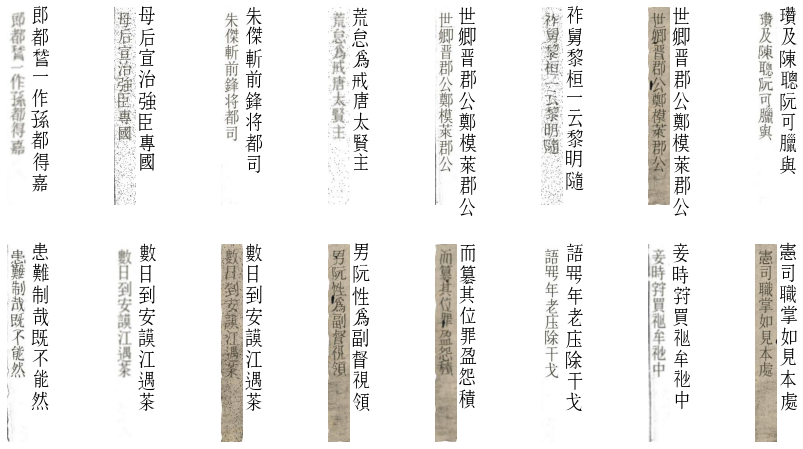

In [8]:
from visualizer import visualize_images_labels
visualize_images_labels(
    dataset.img_paths, 
    dataset.labels, 
    figsize = (15, 8),
    font_path = FONT_PATH, 
    text_x = WIDTH + 3
)

# Define model components

In [9]:
from tensorflow.keras.layers import Input
from layers import custom_cnn, reshape_features
from transformer import TransformerEncoderBlock, TransformerDecoderBlock

## Features extraction

In [10]:
def get_cnn_model(imagenet_model=None, imagenet_output_layer=None, name='CNN_model'):
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)}, 
            
            # Last Conv blocks with 2x2 kernel but without no padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
    
    # Reshape accordingly before passing output to the Transformer encoder
    features = reshape_features(x, dim_to_keep=1)
    return tf.keras.Model(inputs=image_input, outputs=features, name=name)

In [11]:
from models import get_imagenet_model
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

## Transformer encoder and decoder

In [12]:
NUM_LAYERS = 4
NUM_HEADS = 8
EMBEDDING_DIM = 512
FEED_FORWARD_UNITS = 512
DROPOUT_RATE = 0.1

In [13]:
cnn_model = get_cnn_model(imagenet_model, imagenet_output_layer)
encoder = TransformerEncoderBlock(
    receptive_size = cnn_model.layers[-1].output_shape[-2],
    num_layers = NUM_LAYERS, # N encoder layers
    num_heads = NUM_HEADS,
    embedding_dim = EMBEDDING_DIM, # d_model
    feed_forward_units = FEED_FORWARD_UNITS, # dff
    dropout_rate = DROPOUT_RATE,
)
decoder = TransformerDecoderBlock(
    receptive_size = cnn_model.layers[-1].output_shape[-2],
    seq_length = MAX_LENGTH - 1, # the inputs is shifted by 1
    vocab_size = BATCH_SIZE,
    num_layers = NUM_LAYERS, # N decoder layers
    num_heads = NUM_HEADS,
    embedding_dim = EMBEDDING_DIM, # d_model
    feed_forward_units = FEED_FORWARD_UNITS, # dff
    dropout_rate = DROPOUT_RATE,
)

# Build the model

In [14]:
from transformer import TransformerOCR
model = TransformerOCR(cnn_model, encoder, decoder, data_handler)
cnn_model.summary(line_length=90)
print()
encoder.summary(line_length=110)
print()
decoder.summary(line_length=115)
print()

Model: "CNN_model"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 image (InputLayer)                     [(None, 432, 48, 3)]                0             
                                                                                          
 block1_conv1 (Conv2D)                  (None, 432, 48, 64)                 1792          
                                                                                          
 block1_bn1 (BatchNormalization)        (None, 432, 48, 64)                 256           
                                                                                          
 block1_relu1 (Activation)              (None, 432, 48, 64)                 0             
                                                                                          
 block1_pool (MaxPooling2D)             (None, 216, 24, 64)            


Model: "TransformerDecoderBlock"
___________________________________________________________________________________________________________________
 Layer (type)                        Output Shape              Param #       Connected to                          
 decoder_sequence (InputLayer)       [(None, 11)]              0             []                                    
                                                                                                                   
 TokenAndPosEmbedding (TransformerEm  (None, 11, 512)          22016         ['decoder_sequence[0][0]']            
 bedding)                                                                                                          
                                                                                                                   
 embedding_dropout (Dropout)         (None, 11, 512)           0             ['TokenAndPosEmbedding[0][0]']        
                                      

# Training

In [ ]:
train_idxs = list(range(int(dataset.size * 0.8)))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

In [ ]:
import random
random.seed(2022)
random.shuffle(train_idxs)
random.shuffle(valid_idxs)

In [ ]:
# When run on a small RAM machine, you can set use_cache=False to 
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(
    train_idxs, BATCH_SIZE, drop_remainder=True
)
valid_tf_dataset = data_handler.prepare_tf_dataset(
    valid_idxs, BATCH_SIZE, drop_remainder=True
)

## Callbacks

In [ ]:
from callbacks import EarlyStoppingWithStuck
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Train the IHR-NomDB dataset

In [ ]:
from losses import MaskedLoss
from metrics import SequenceAccuracy, CharacterAccuracy, LevenshteinDistance
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [ ]:
model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)

In [ ]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [reduce_lr_callback, early_stopping_callback],
    verbose = 1
).history

## Save the training results

In [ ]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_lev_distance"][best_epoch]}')

In [ ]:
from visualizer import plot_training_results
plot_training_results(history, f'{APPROACH_NAME}.png')
model.encoder.save_weights(f'{APPROACH_NAME}_encoder.h5')
model.decoder.save_weights(f'{APPROACH_NAME}_decoder.h5')

# Inference

In [ ]:
encoder = Encoder(imagenet_model, imagenet_output_layer)
decoder = Decoder(encoder.output_shape[1:])
encoder.load_weights(f'{APPROACH_NAME}_encoder.h5')
decoder.load_weights(f'{APPROACH_NAME}_decoder.h5')

In [ ]:
reset_model = EncoderDecoderModel(encoder, decoder, data_handler, dec_rnn_name='dec_gru')
reset_model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)
reset_model.evaluate(valid_tf_dataset)

## On test dataset

In [ ]:
batch_results = []
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(2)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens, attentions = reset_model.predict(batch_images, return_attention=True)
    pred_labels = data_handler.tokens2texts(pred_tokens)
    
    batch_results.append({'true': labels, 'pred': pred_labels, 'attentions': attentions})
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        figsize = (14, 20),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.28),
        annotate_loc = (4, 1.8),
        font_path = FONT_PATH, 
        text_x = WIDTH + 5 # Position of actual label to plot
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [ ]:
random_path = '../囷𦝄苔惮󰞺𧍋𦬑囊.jpg'
random_label = '囷𦝄苔惮󰞺𧍋𦬑囊'
random_image = data_handler.process_image(random_path)
pred_tokens = reset_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens)

In [ ]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    font_path = FONT_PATH, 
    text_x = 40 # Position to plot actual label
)
print('Predicted text:', ''.join(pred_labels))